In [4]:
import lightgbm
import numpy as np
import pandas as pd

## Generate Predictions Func

In [5]:
def generate_predictions(df_kpi, date_uploaded, model_object, backtesting_limit=360):
    df_kpi = df_kpi[df_kpi['backtesting_limit'] == backtesting_limit].reset_index().drop(columns = 'index')
    col_720 = [col for col in df_kpi.columns if '_720' in col]
    col_630 = [col for col in df_kpi.columns if '_630' in col]
    col_540 = [col for col in df_kpi.columns if '_540' in col]
    col_450 = [col for col in df_kpi.columns if '_450' in col]

    col_450_540_630_720 = col_720+col_630+col_540+col_450
    col_540_630_720 = col_720+col_630+col_540
    col_630_720 = col_720+col_630

    df_kpi.loc[(df_kpi['cohort_age_backtesting']==360),col_450_540_630_720] = np.nan
    df_kpi.loc[(df_kpi['cohort_age_backtesting']==450),col_540_630_720] = np.nan
    df_kpi.loc[(df_kpi['cohort_age_backtesting']==540),col_630_720] = np.nan
    df_kpi.loc[(df_kpi['cohort_age_backtesting']==630),col_720] = np.nan
    
    preds = model_object.predict(df_kpi[model_object.feature_name()])
    df_kpi["predictions"] = preds
    
    for months in [360, 450, 540, 630, 720]:
        frr_col = f"frr_{months}"
        mask = (df_kpi["age_in_months"] == months) & (df_kpi[frr_col] > df_kpi["predictions"])
        df_kpi.loc[mask, "predictions"] = df_kpi[frr_col]

    df_kpi["predictions"] = df_kpi["predictions"].clip(lower=0, upper=1)
    df_kpi["date_uploaded"] = date_uploaded
    df_kpi["date_uploaded"] = pd.to_datetime(df_kpi["date_uploaded"], format="%Y-%m-%d")
    df_kpi["reg_month"] = pd.to_datetime(df_kpi["reg_month"], format="%Y-%m")
    df_kpi["predicted_revenue_3_years_50"] = np.round(df_kpi['predictions']*df_kpi['total_follow_on_revenue_current_usd'],2)
    return df_kpi

def expand_rows(df, horizon_steps=[360, 450, 540, 630, 720]):
    df_rep = df.loc[df.index.repeat(len(horizon_steps))].copy()
    df_rep["current_horizon"] = np.tile(horizon_steps, len(df))
    df_rep = df_rep[df_rep["current_horizon"] <= df_rep["cohort_age_backtesting"]]

    feature_cols = [c for c in df.columns if any(c.endswith(f"_{h}") for h in horizon_steps)]
    for col in feature_cols:
        feat_h = int(col.split("_")[-1])
        df_rep.loc[df_rep["current_horizon"] < feat_h, col] = np.nan

    return df_rep.reset_index(drop=True)


## Load Data

In [6]:
# model_1 = lightgbm.Booster(model_file = "quantile_regression_360_0.5_days_2025-09-29.txt")

model_1 = lightgbm.Booster(model_file = "../models/quantile_regression_360_0.5_days_2025-02-23.txt")

In [7]:
kpi_processed_file = '../data/KPIs_data_processed_2025-09-01.csv'
df_kpi = pd.read_csv(kpi_processed_file)
df_kpi_expanded = expand_rows(df_kpi, horizon_steps=[360, 450, 540, 630, 720])
df_preds_sep = generate_predictions(df_kpi=df_kpi_expanded, date_uploaded="2025-09-01", model_object=model_1, backtesting_limit=360)

kpi_processed_file = '../data/KPIs_data_processed_2025-08-01.csv'
df_kpi = pd.read_csv(kpi_processed_file)
df_kpi_expanded = expand_rows(df_kpi, horizon_steps=[360, 450, 540, 630, 720])
df_preds_aug = generate_predictions(df_kpi=df_kpi_expanded, date_uploaded="2025-08-01", model_object=model_1, backtesting_limit=360)

df2 = pd.concat([df_preds_sep, df_preds_aug])
print(df2.shape)
df2_copy = df2.copy()

(1443950, 93)


## Example Data Point

In [ ]:
df2_copy[df2_copy.accounts_group=='2024-05_Kenya_Lanterns_Kakamega_Sun King Boom EasyBuy'][["accounts_group", "frr_360", "frr_450", "frr_540", "cohort_age_backtesting", "current_horizon","date_uploaded", "predictions"]]#.to_csv("test.csv", index=False)

,accounts_group,frr_360,frr_450,frr_540,cohort_age_backtesting,current_horizon,date_uploaded,predictions
712863,2024-05_Kenya_Lanterns_Kakamega_Sun King Boom ...,0.564007,NaN,NaN,450,360,2025-09-01,0.901629
712864,2024-05_Kenya_Lanterns_Kakamega_Sun King Boom ...,0.564007,0.672026,NaN,450,450,2025-09-01,0.883211
701152,2024-05_Kenya_Lanterns_Kakamega_Sun King Boom ...,0.564007,NaN,NaN,360,360,2025-08-01,0.901629


: 

In [9]:
(0.870390+0.877586)/2

0.873988

In [10]:
df2= df2.drop(["current_horizon", "predicted_revenue_3_years_50"], axis=1, errors="ignore")
df2

,accounts_group,reg_month,country,product_group,area,primary_product,count_units,avg_planned_repayment_days,total_follow_on_revenue_current_usd,total_follow_on_revenue,...,age_in_months,exchange,total_follow_on_revenue_usd_cal,total_follow_on_revenue_usd_final,avg_upfront_price_usd,avg_unlock_price_usd,backtesting_limit,cohort_age_backtesting,predictions,date_uploaded
0,2016-01_Kenya_Lanterns_Kakamega_Sun King Pro E...,2016-01-01,Kenya,Lanterns,Kakamega,Sun King Pro EasyBuy,57,77,1543.400856,199500.0,...,115,152.85,1305.2012,1305.201200,7.0,30.0,360,720,0.952404,2025-09-01
1,2016-01_Kenya_Lanterns_Kakamega_Sun King Pro E...,2016-01-01,Kenya,Lanterns,Kakamega,Sun King Pro EasyBuy,57,77,1543.400856,199500.0,...,115,152.85,1305.2012,1305.201200,7.0,30.0,360,720,0.960073,2025-09-01
2,2016-01_Kenya_Lanterns_Kakamega_Sun King Pro E...,2016-01-01,Kenya,Lanterns,Kakamega,Sun King Pro EasyBuy,57,77,1543.400856,199500.0,...,115,152.85,1305.2012,1305.201200,7.0,30.0,360,720,0.964076,2025-09-01
3,2016-01_Kenya_Lanterns_Kakamega_Sun King Pro E...,2016-01-01,Kenya,Lanterns,Kakamega,Sun King Pro EasyBuy,57,77,1543.400856,199500.0,...,115,152.85,1305.2012,1305.201200,7.0,30.0,360,720,0.975394,2025-09-01
4,2016-01_Kenya_Lanterns_Kakamega_Sun King Pro E...,2016-01-01,Kenya,Lanterns,Kakamega,Sun King Pro EasyBuy,57,77,1543.400856,199500.0,...,115,152.85,1305.2012,1305.201200,7.0,30.0,360,720,0.977491,2025-09-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712181,2024-07_Zambia_SHS without TV_Mumbwa_Sun King ...,2024-07-01,Zambia,SHS without TV,Mumbwa,Sun King Home 500x EasyBuy,16,371,3222.458521,75760.0,...,12,25.30,2994.4664,2989.077783,20.0,207.0,360,360,0.957924,2025-08-01
712182,2024-07_Zambia_SHS without TV_Ndola_Sun King H...,2024-07-01,Zambia,SHS without TV,Ndola,Sun King Home 500x EasyBuy,86,360,17323.692008,407280.0,...,12,25.30,16098.0237,16069.054905,21.0,208.0,360,360,0.996987,2025-08-01
712183,2024-07_Zambia_SHS without TV_Serenje_Sun King...,2024-07-01,Zambia,SHS without TV,Serenje,Sun King Home 500x EasyBuy,4,381,826.882176,19440.0,...,12,25.30,768.3794,766.996728,20.0,211.0,360,360,0.994883,2025-08-01
712184,2024-07_Zambia_SHS without TV_Situmbeko_Sun Ki...,2024-07-01,Zambia,SHS without TV,Situmbeko,Sun King Home 500x EasyBuy,20,381,4134.410880,97200.0,...,12,25.30,3841.8972,3834.983640,20.0,211.0,360,360,0.994419,2025-08-01


In [11]:
df = df2.groupby(["accounts_group", "reg_month", "country", "product_group", "area", "primary_product", "count_units", "total_follow_on_revenue_current_usd", "date_uploaded"]).agg(
    predicted_frr_agg= ("predictions", "mean")
).reset_index()

In [12]:
df[df.accounts_group=='2024-05_Kenya_Lanterns_Kakamega_Sun King Boom EasyBuy']

,accounts_group,reg_month,country,product_group,area,primary_product,count_units,total_follow_on_revenue_current_usd,date_uploaded,predicted_frr_agg
305835,2024-05_Kenya_Lanterns_Kakamega_Sun King Boom ...,2024-05-01,Kenya,Lanterns,Kakamega,Sun King Boom EasyBuy,1360,85391.659890,2025-08-01,0.901629
305836,2024-05_Kenya_Lanterns_Kakamega_Sun King Boom ...,2024-05-01,Kenya,Lanterns,Kakamega,Sun King Boom EasyBuy,1360,85398.266724,2025-09-01,0.892420


In [13]:
df["predicted_revenue_3_years"] = np.round(df['predicted_frr_agg']*df['total_follow_on_revenue_current_usd'],2)

## Visuals by Country

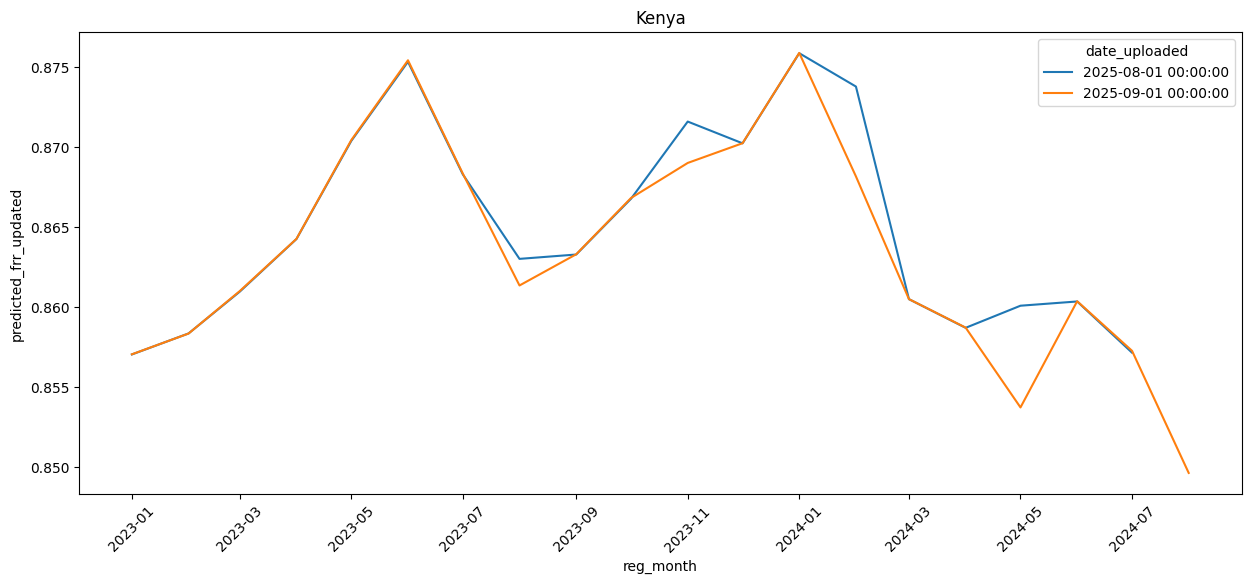

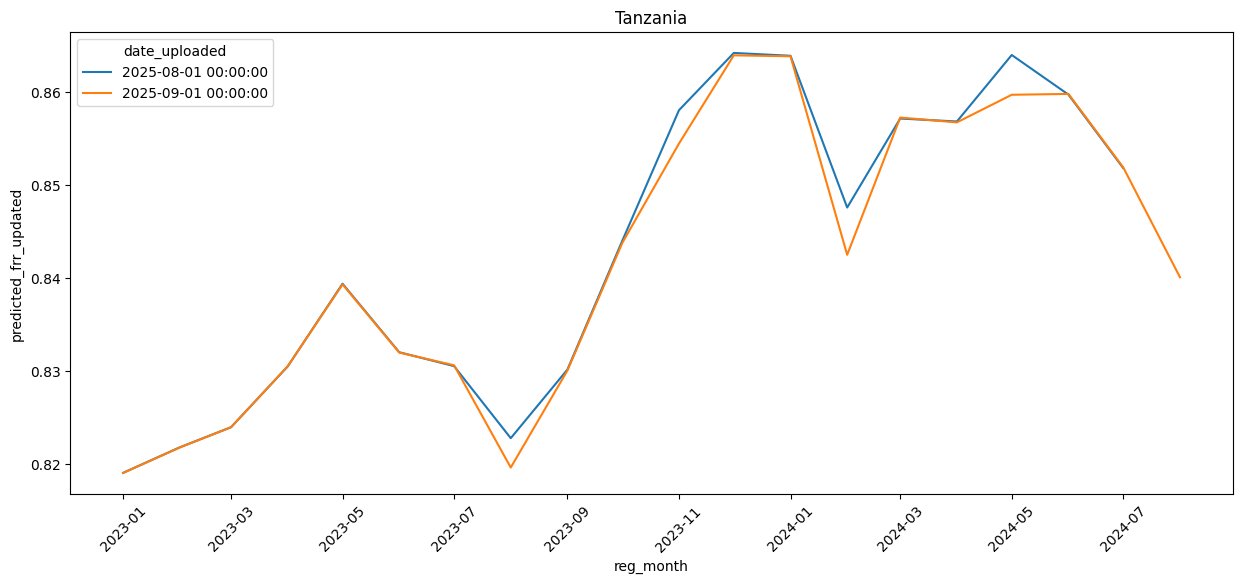

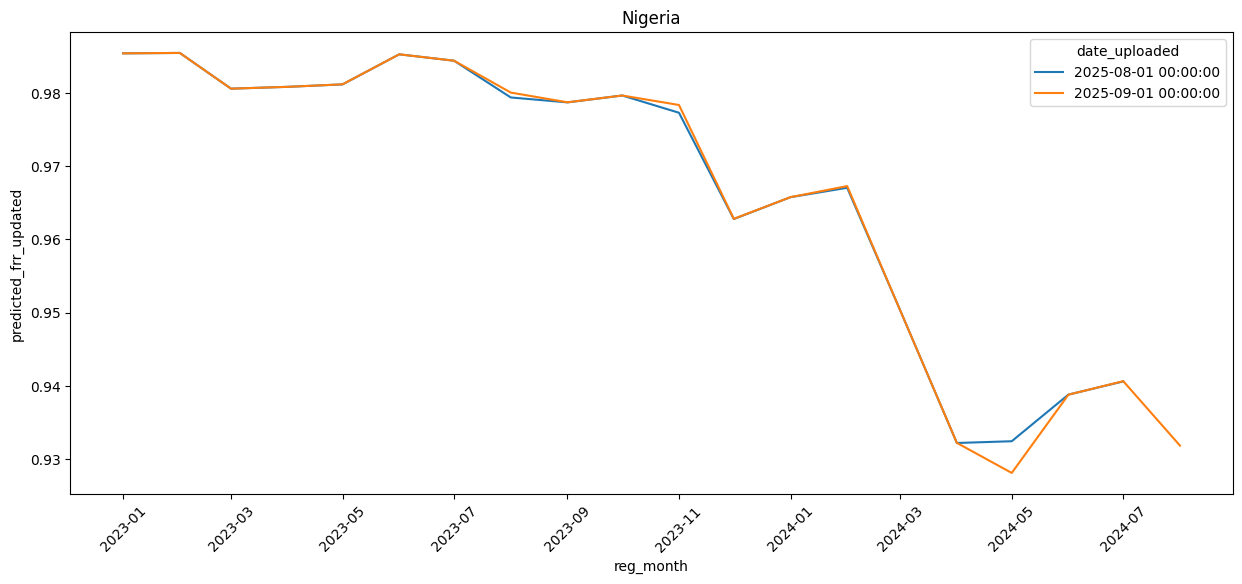

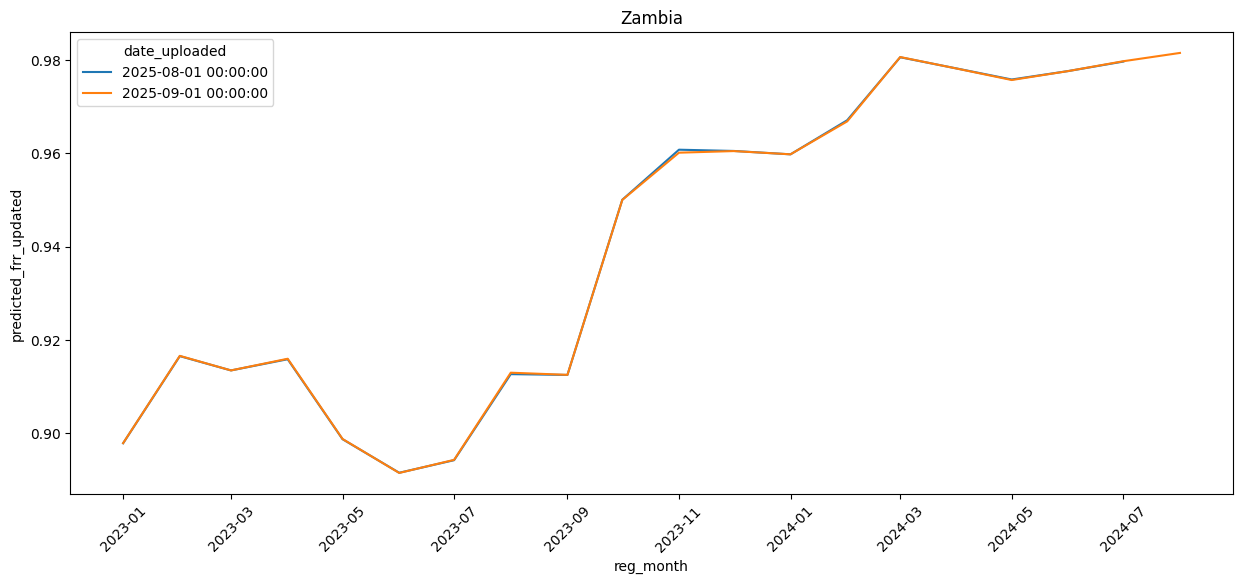

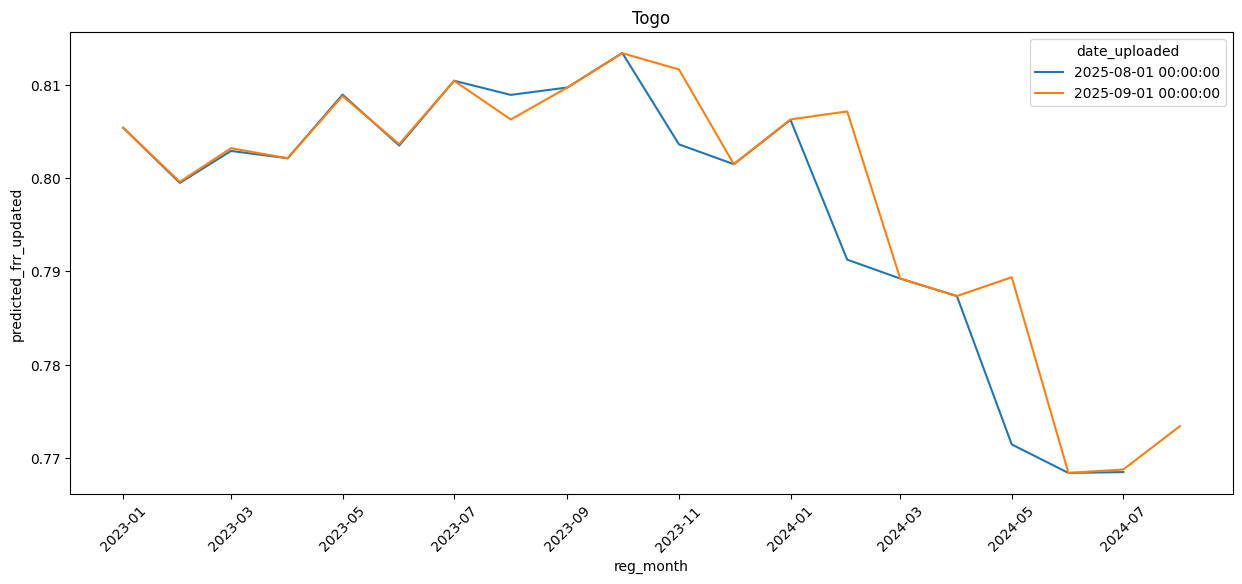

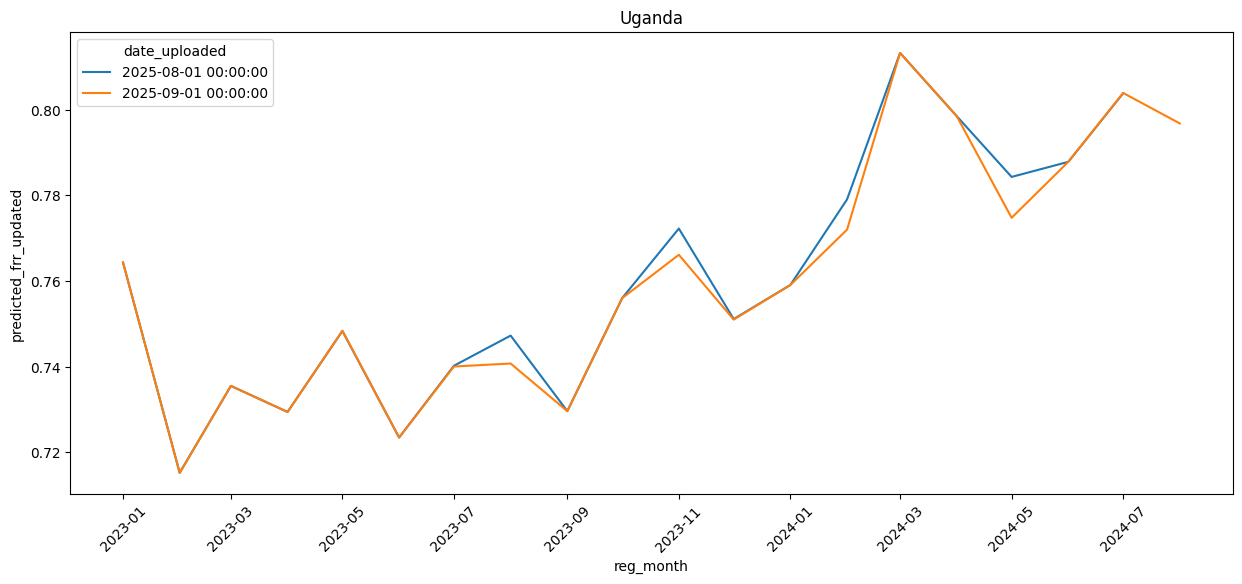

In [14]:
from matplotlib import pyplot as plt
import seaborn as sns

df_country = df.groupby(["country", "reg_month", "date_uploaded"]).agg(
    count_average=("count_units", lambda x: int(x.mean())),
    predicted_fr = ("predicted_revenue_3_years", "sum"),
    total_fr = ("total_follow_on_revenue_current_usd", "sum")
).reset_index()
df_country["predicted_frr_updated"] = df_country.predicted_fr/df_country.total_fr
df_country = df_country.drop(['total_fr', 'predicted_fr'], axis=1)
# products = ["Lanterns", "Phones", "SHS Entry-Level", "SHS with TV", "SHS without TV", "SHS Entry-Level Upgrade", "SHS with TV Upgrade"]
# df_country = df_country[df_country.product_group.isin(products)]
df_country

for country in ["Kenya", "Tanzania", "Nigeria", "Zambia", "Togo", "Uganda"]:
    plt.figure(figsize=(15, 6))
    sns.lineplot(data=df_country[(df_country.country==country) & (df_country.reg_month>="2023-01-01")], x="reg_month", y="predicted_frr_updated",\
                  hue="date_uploaded")
    # sns.lineplot(data=df_country, x="reg_month", y="frr_prediction_50")
    plt.xticks(rotation=45)
    plt.title(country)
    plt.show()

In [15]:
df_country[df_country["reg_month"]=="2024-05-01"]

,country,reg_month,date_uploaded,count_average,predicted_frr_updated
36,Cameroon,2024-05-01,2025-08-01,20,0.934670
37,Cameroon,2024-05-01,2025-09-01,20,0.926610
197,India,2024-05-01,2025-08-01,5,0.814974
198,India,2024-05-01,2025-09-01,5,0.813815
403,Kenya,2024-05-01,2025-08-01,73,0.860105
404,Kenya,2024-05-01,2025-09-01,73,0.853746
442,Malawi,2024-05-01,2025-08-01,106,0.978811
443,Malawi,2024-05-01,2025-09-01,106,0.977804
511,Mozambique,2024-05-01,2025-08-01,27,0.807880
512,Mozambique,2024-05-01,2025-09-01,27,0.798100


In [16]:
0.851948 - 0.859237

-0.00728899999999999

## Visuals by Country and Product

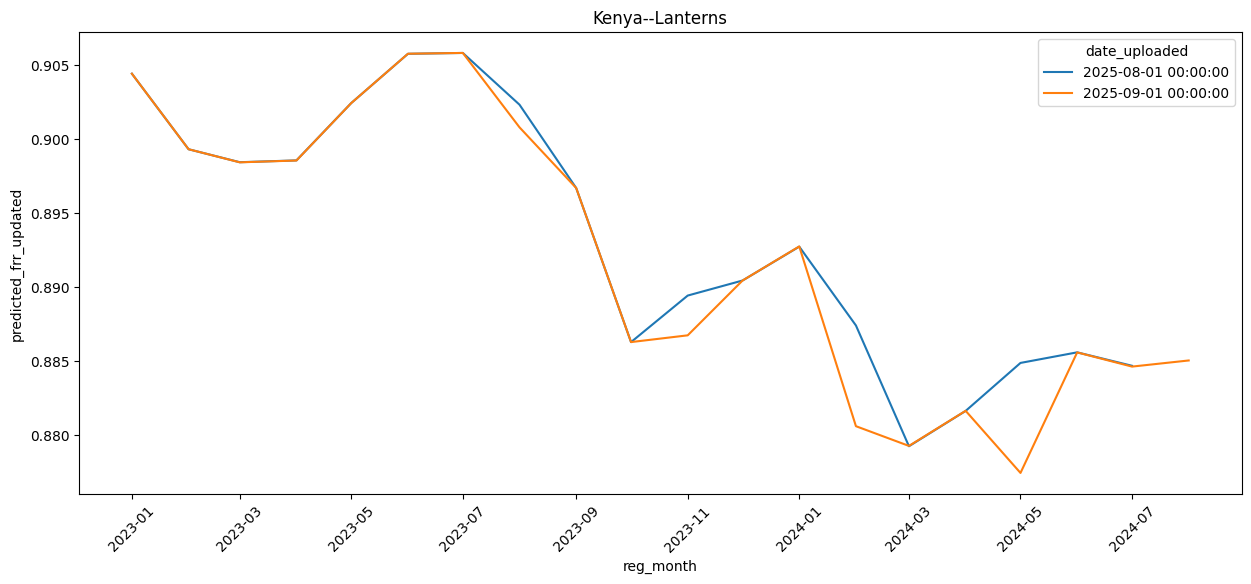

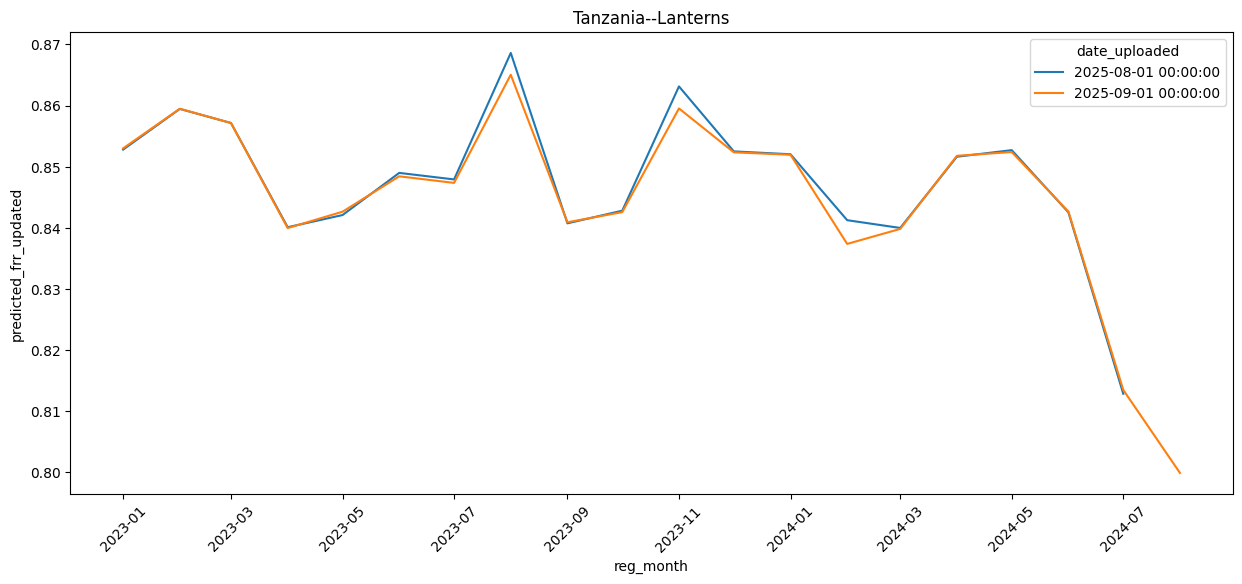

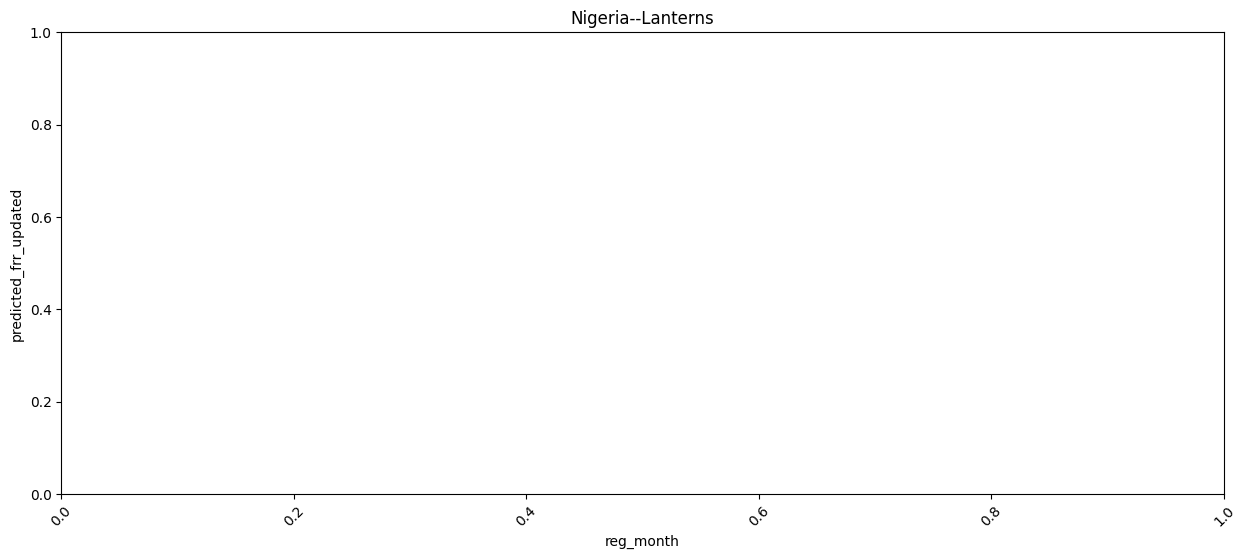

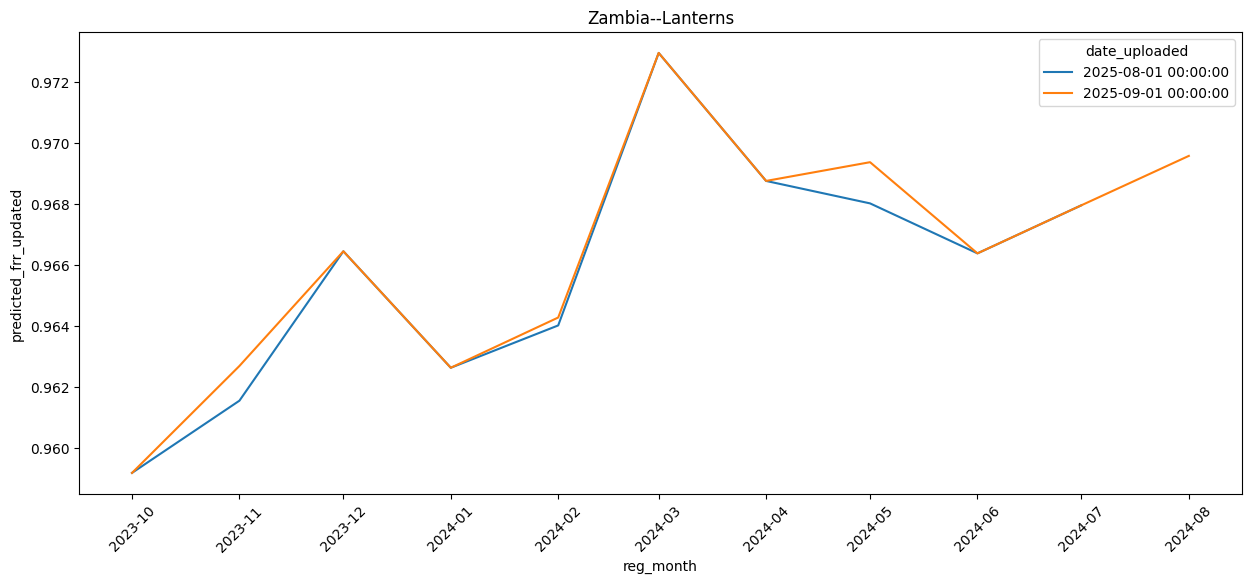

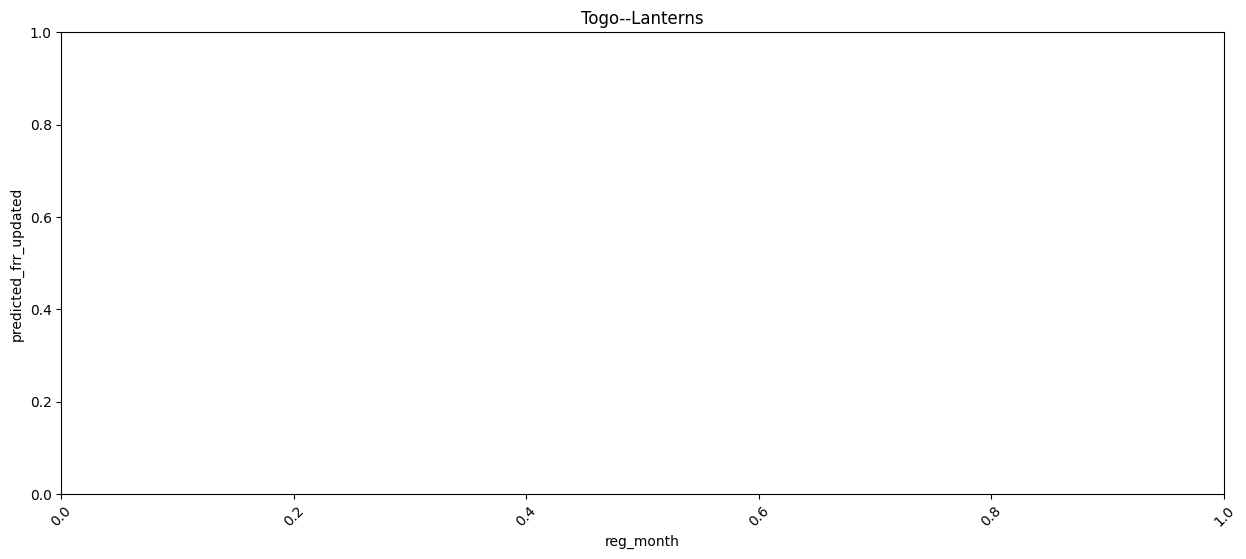

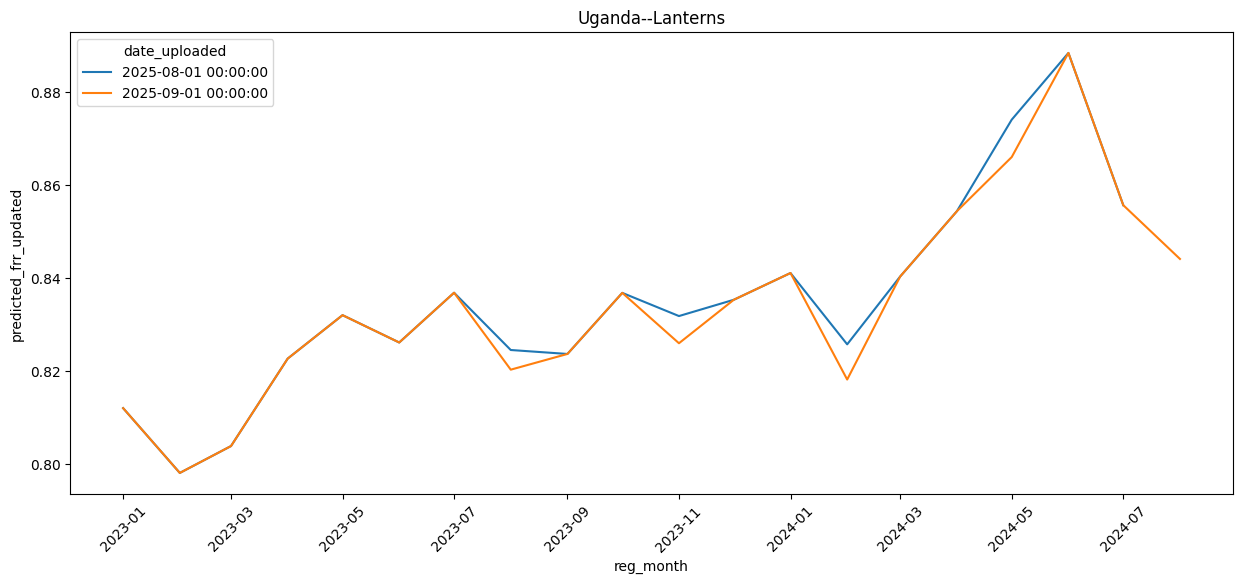

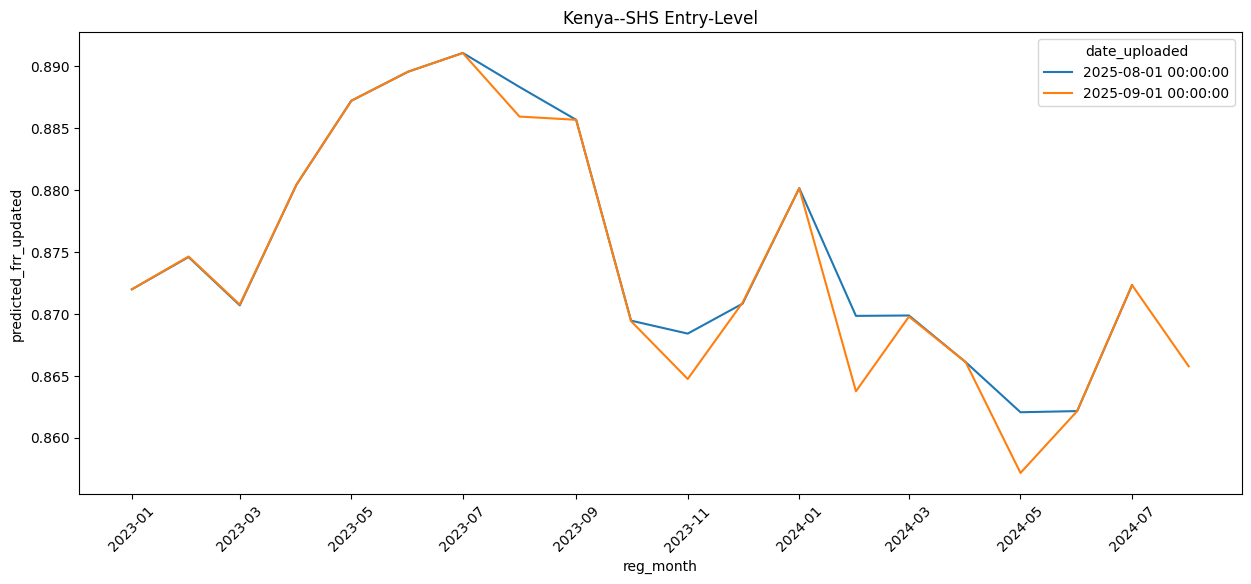

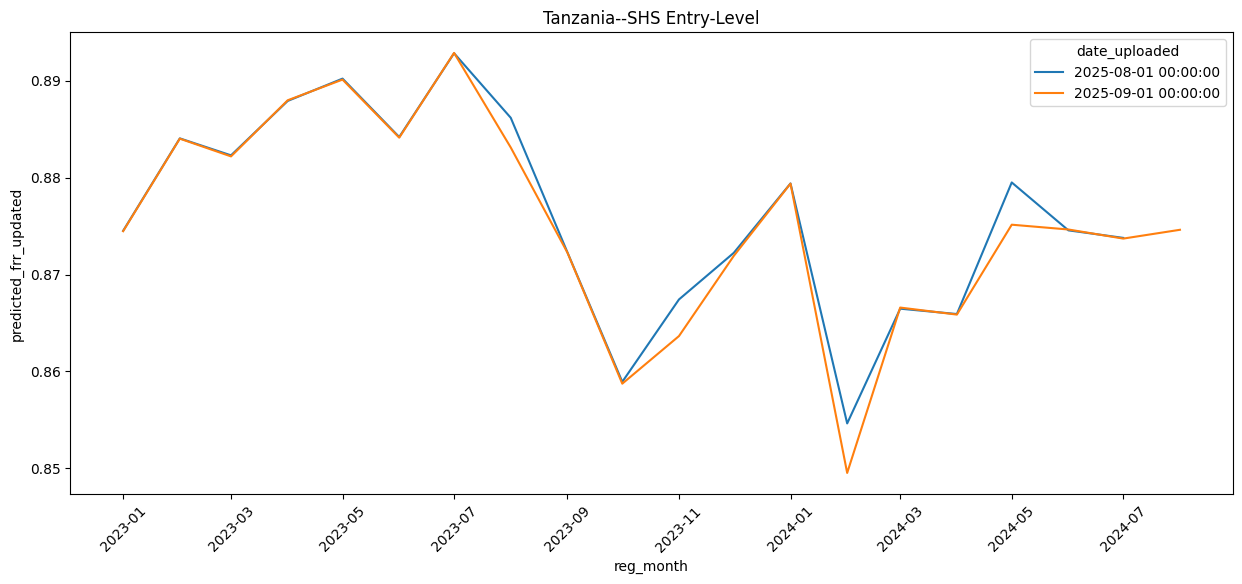

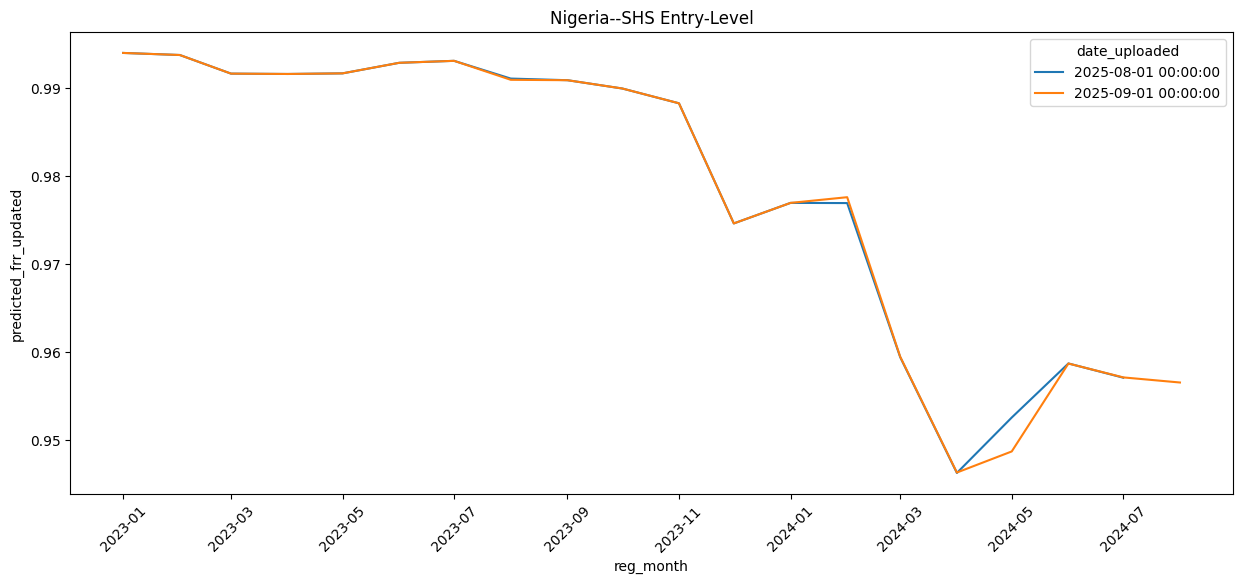

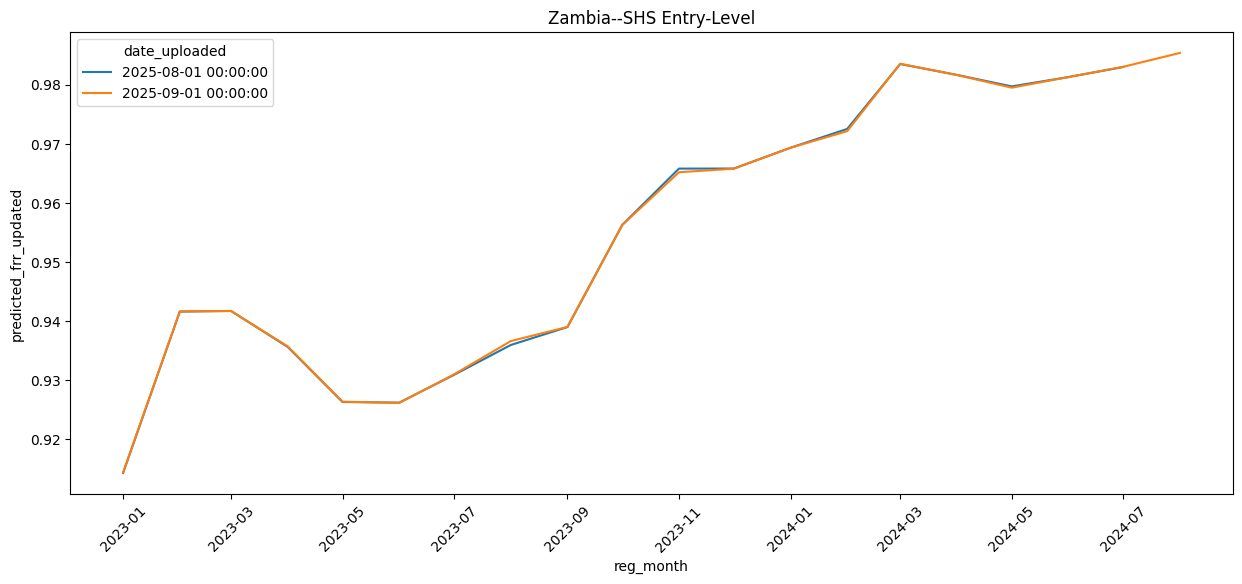

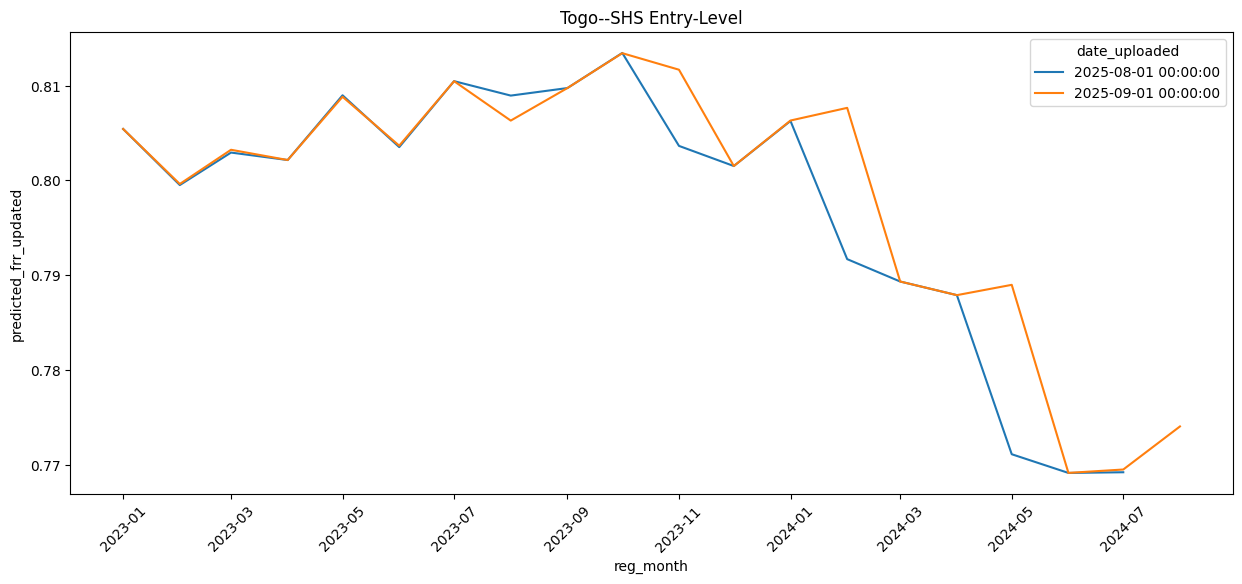

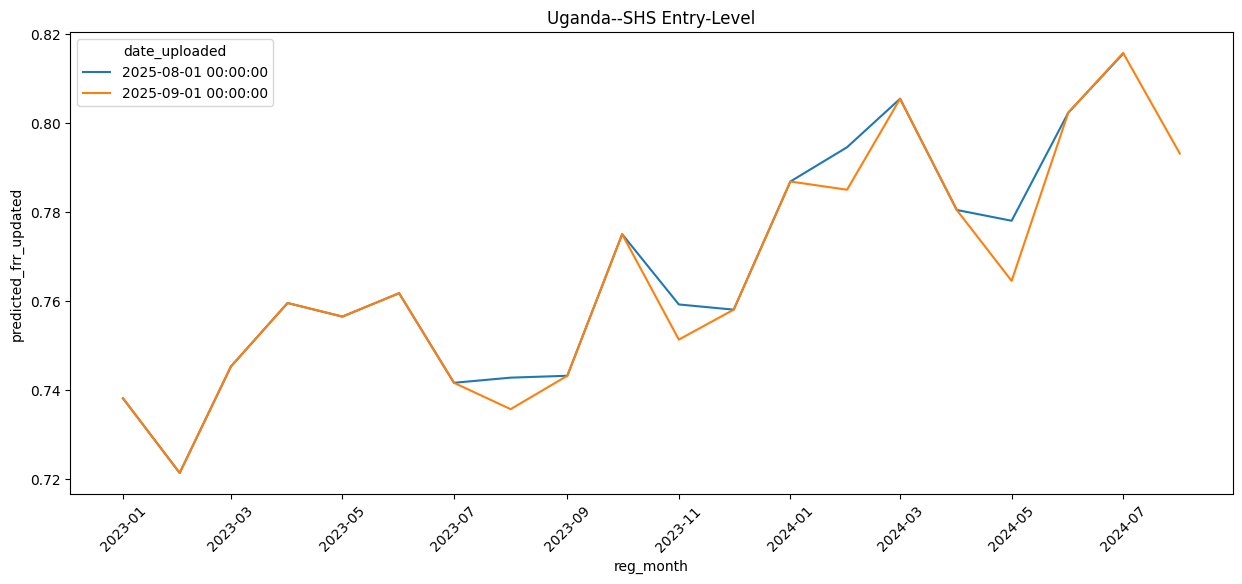

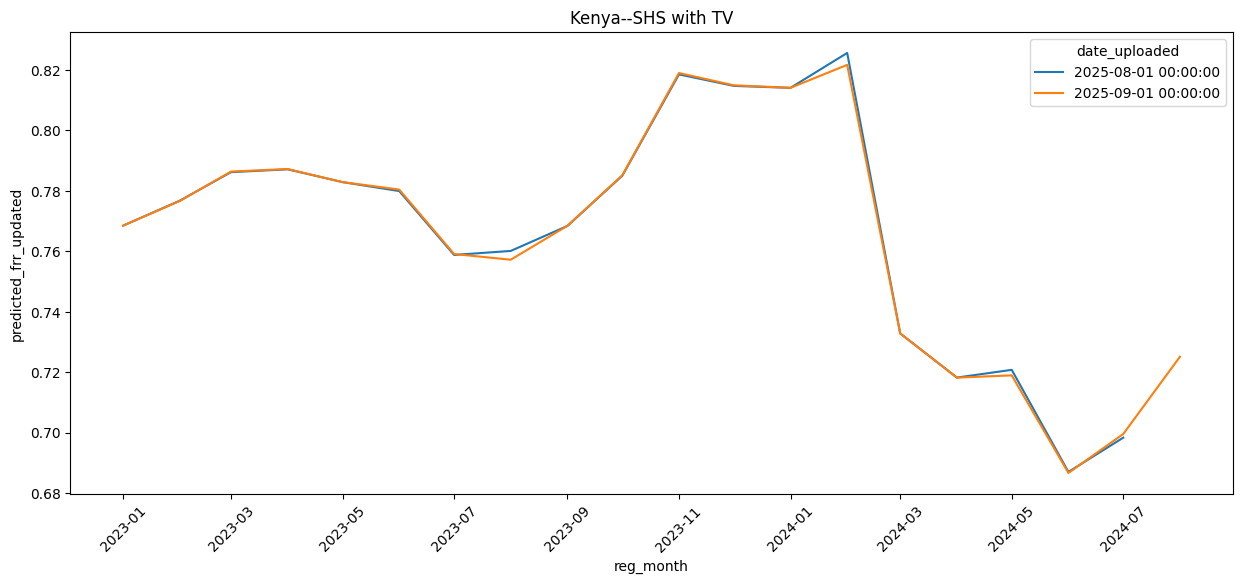

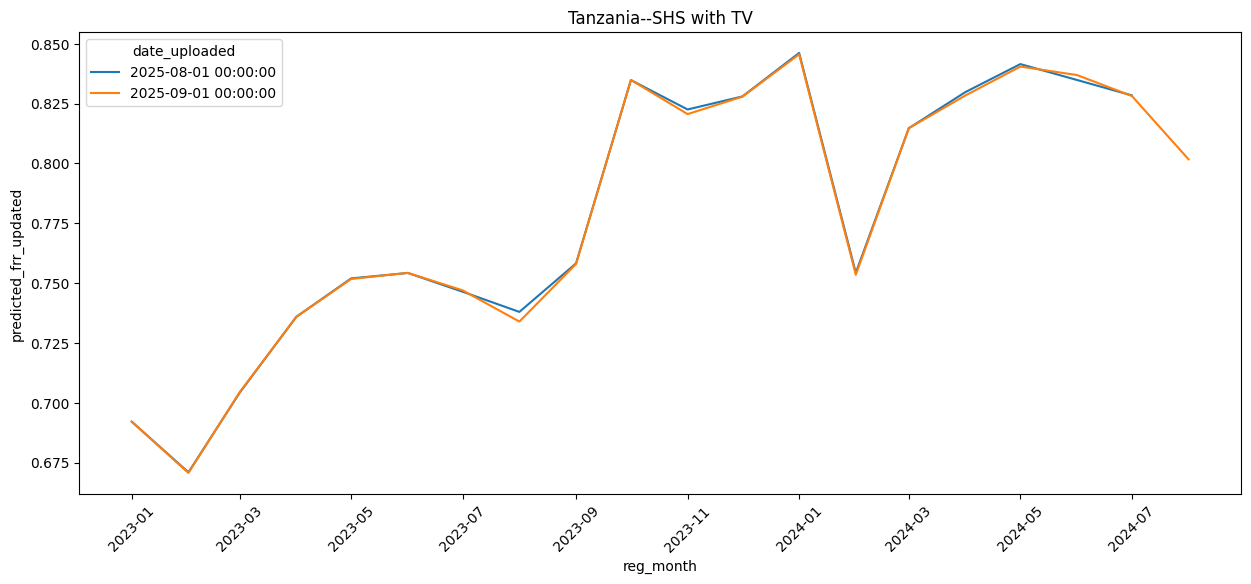

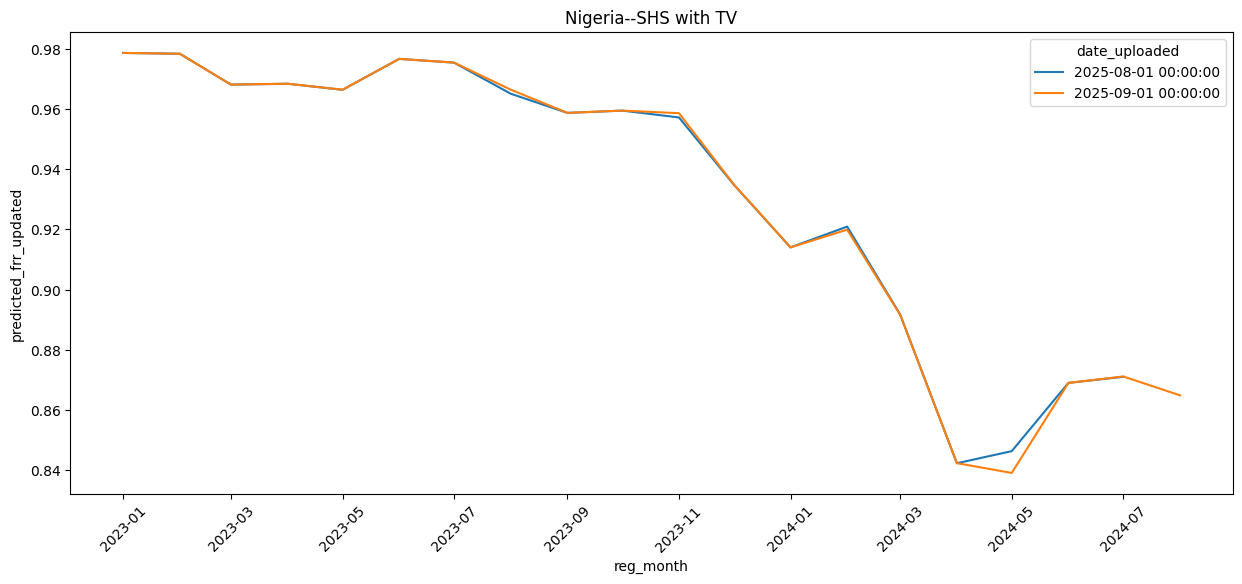

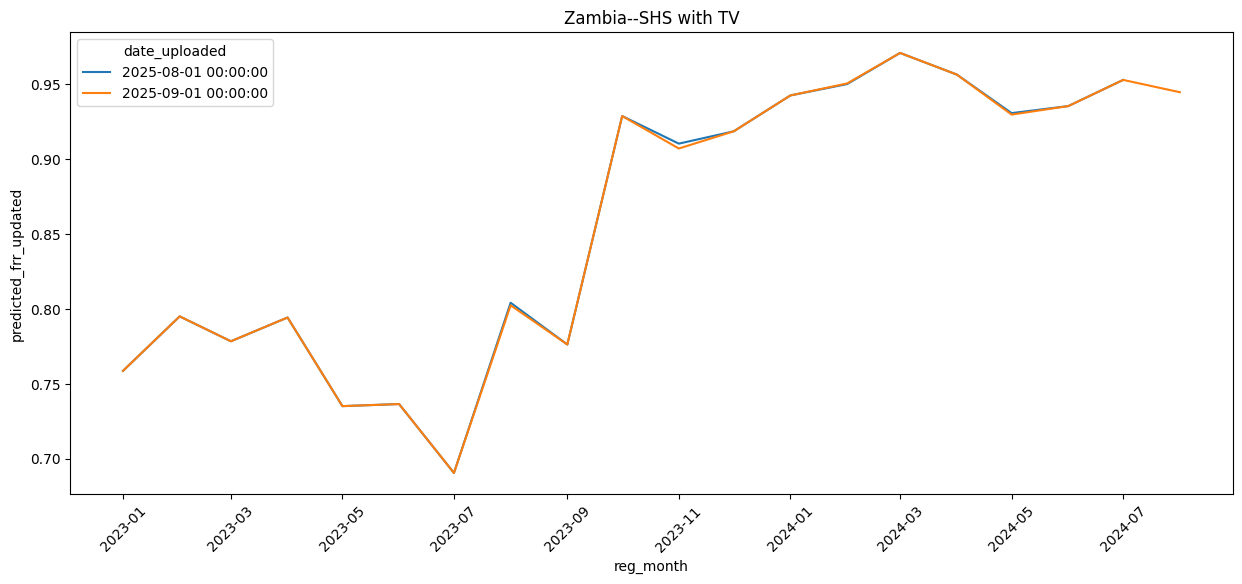

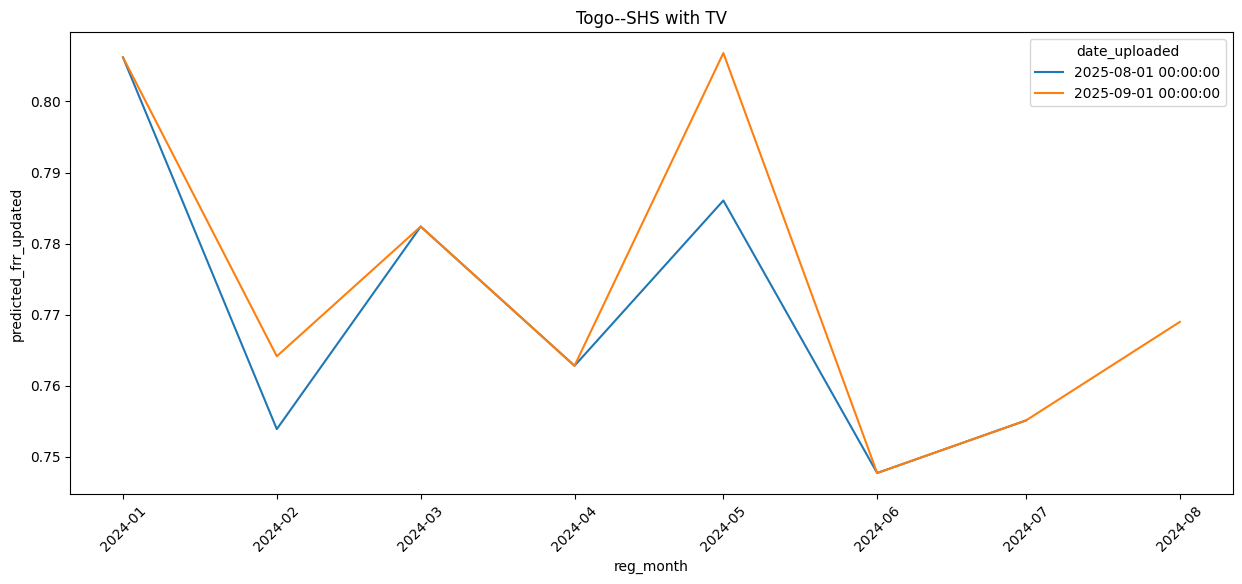

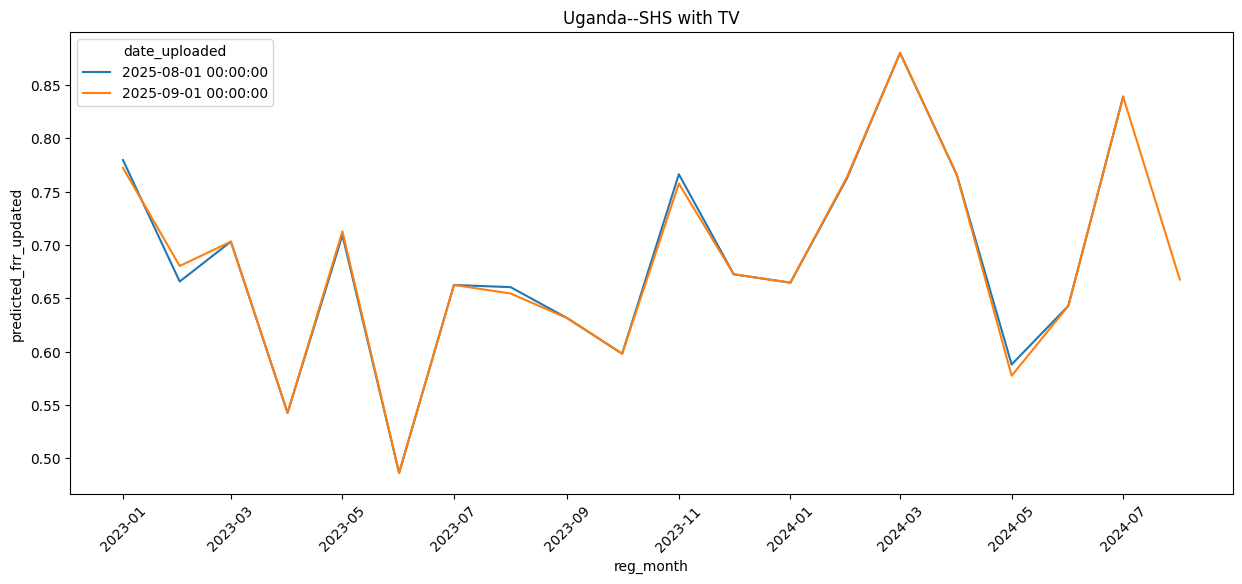

In [17]:
from matplotlib import pyplot as plt
import seaborn as sns

df_product = df.groupby(["country", "product_group","reg_month", "date_uploaded"]).agg(
    count_average=("count_units", lambda x: int(x.mean())),
    predicted_fr = ("predicted_revenue_3_years", "sum"),
    total_fr = ("total_follow_on_revenue_current_usd", "sum")
).reset_index()
df_product["predicted_frr_updated"] = df_product.predicted_fr/df_product.total_fr
df_product = df_product.drop(['total_fr', 'predicted_fr'], axis=1)
# products = ["Lanterns", "Phones", "SHS Entry-Level", "SHS with TV", "SHS without TV", "SHS Entry-Level Upgrade", "SHS with TV Upgrade"]
# df_product = df_product[df_product.product_group.isin(products)]
df_product

for product_group in ["Lanterns", "SHS Entry-Level", "SHS with TV"]:
    for country in ["Kenya", "Tanzania", "Nigeria", "Zambia", "Togo", "Uganda"]:
        plt.figure(figsize=(15, 6))
        sns.lineplot(data=df_product[(df_product.country==country) & (df_product.product_group==product_group) & (df_product.reg_month>="2023-01-01")], x="reg_month", y="predicted_frr_updated",\
                    hue="date_uploaded")
        # sns.lineplot(data=df_product, x="reg_month", y="frr_prediction_50")
        plt.xticks(rotation=45)
        plt.title(f"{country}--{product_group}")
        plt.show()

In [18]:
df_product[(df_product["reg_month"]=="2024-05-01") & (df_product.country=="Kenya") & (df_product.product_group=="Lanterns")]

,country,product_group,reg_month,date_uploaded,count_average,predicted_frr_updated
863,Kenya,Lanterns,2024-05-01,2025-08-01,433,0.884858
864,Kenya,Lanterns,2024-05-01,2025-09-01,433,0.877409


In [19]:
0.873753-0.867906

0.005847000000000047

In [20]:
pivoted = df_product.pivot_table(
    index=["country", "product_group","reg_month",],
    columns="date_uploaded",
    values=["predicted_frr_updated", "count_average"]
).reset_index()
pivoted.columns = [
    str(c[0]) if c[1] == "" or pd.isna(c[1]) else f"{c[0]}_{c[1].date()}"
    for c in pivoted.columns.to_flat_index()
]
pivoted["reg_month"] = pd.to_datetime(pivoted["reg_month"])

pivoted["diff"] = pivoted["predicted_frr_updated_2025-09-01"] - pivoted["predicted_frr_updated_2025-08-01"]
pivoted.head()

backtestings = np.array([30, 60, 90, 180, 270, 360, 450, 540, 630, 720], dtype=int)
months = backtestings // 30

base_current = pd.to_datetime("2025-09-01")
base_prev = pd.to_datetime("2025-08-01")

backtesting_month_current = [base_current - pd.DateOffset(months=m+1) for m in months]
backtesting_month_prev = [base_prev - pd.DateOffset(months=m+2) for m in months]

data = {
    "Months": months,
    "backtesting_month_current": backtesting_month_current,
    "backtesting_month_prev": backtesting_month_prev,
    "backtesting_shift": backtestings,
}
backtestings_df = pd.DataFrame(data)

print(backtestings_df)

discrepancies = pd.merge(left=pivoted, right=backtestings_df, left_on="reg_month", right_on="backtesting_month_current", how="left")
discrepancies["backtesting_shift"] = discrepancies["backtesting_shift"].astype("Int64")
discrepancies = discrepancies[discrepancies.backtesting_shift.isin([450, 540, 630, 720])]

# discrepancies["diff"] = (discrepancies["predicted_frr_updated_2025-08"] - discrepancies["predicted_frr_updated_2025-07"]).round(4)*100


   Months backtesting_month_current backtesting_month_prev  backtesting_shift
0       1                2025-07-01             2025-05-01                 30
1       2                2025-06-01             2025-04-01                 60
2       3                2025-05-01             2025-03-01                 90
3       6                2025-02-01             2024-12-01                180
4       9                2024-11-01             2024-09-01                270
5      12                2024-08-01             2024-06-01                360
6      15                2024-05-01             2024-03-01                450
7      18                2024-02-01             2023-12-01                540
8      21                2023-11-01             2023-09-01                630
9      24                2023-08-01             2023-06-01                720


In [21]:
discrepancies_country = discrepancies.groupby(["country", "reg_month", "product_group", "backtesting_shift"]).agg(diff2=("diff", "mean")).reset_index()

## DIffs at Backtesting shift

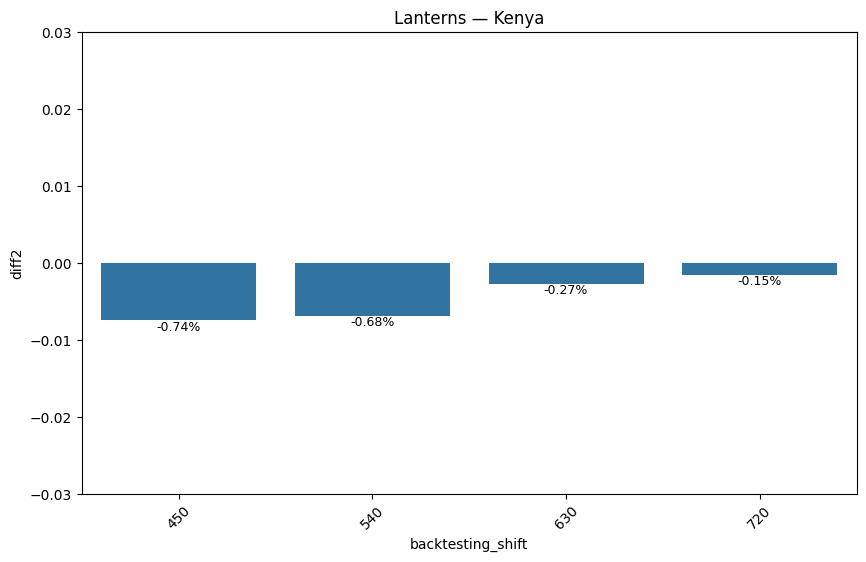

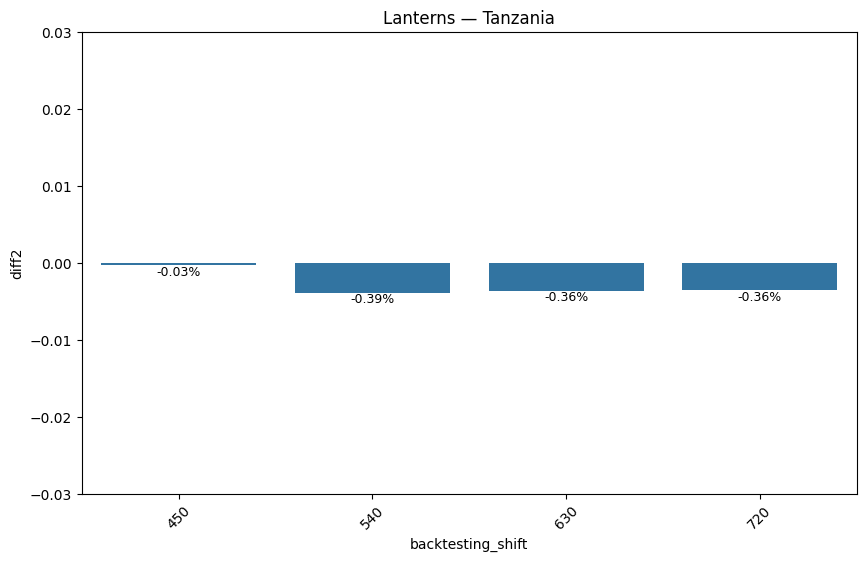

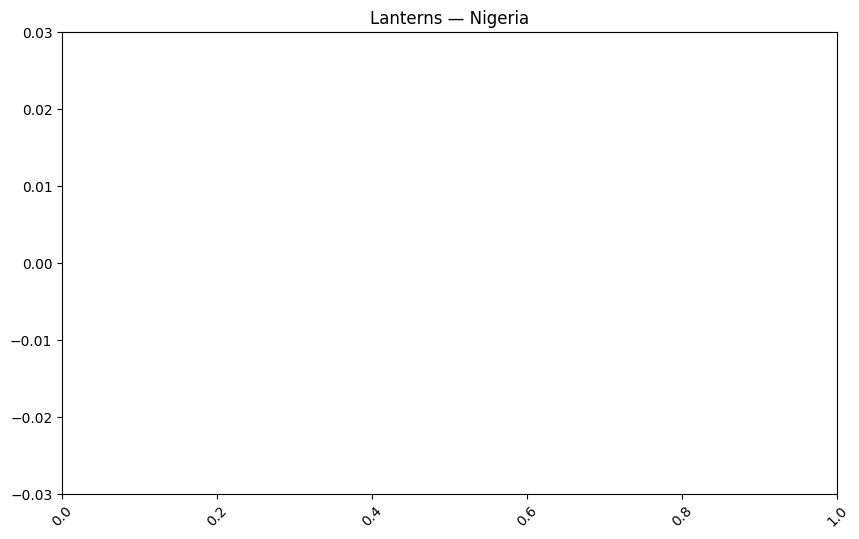

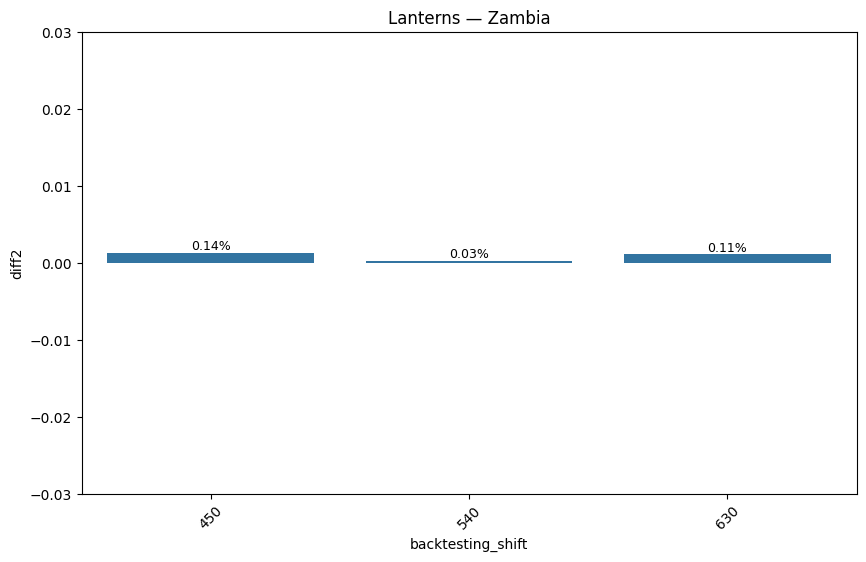

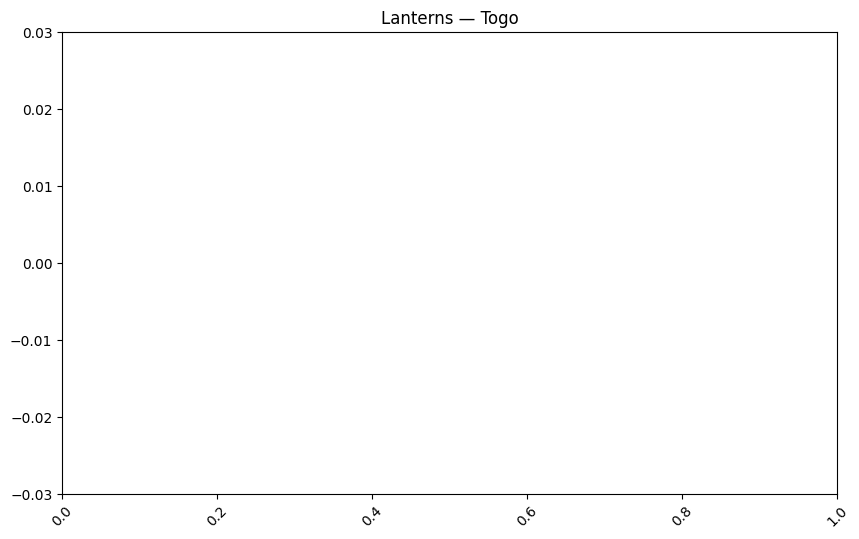

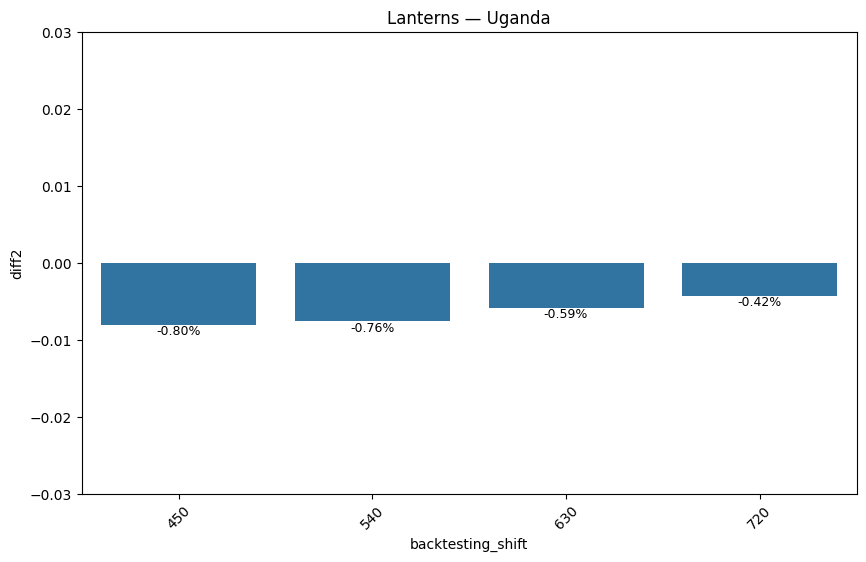

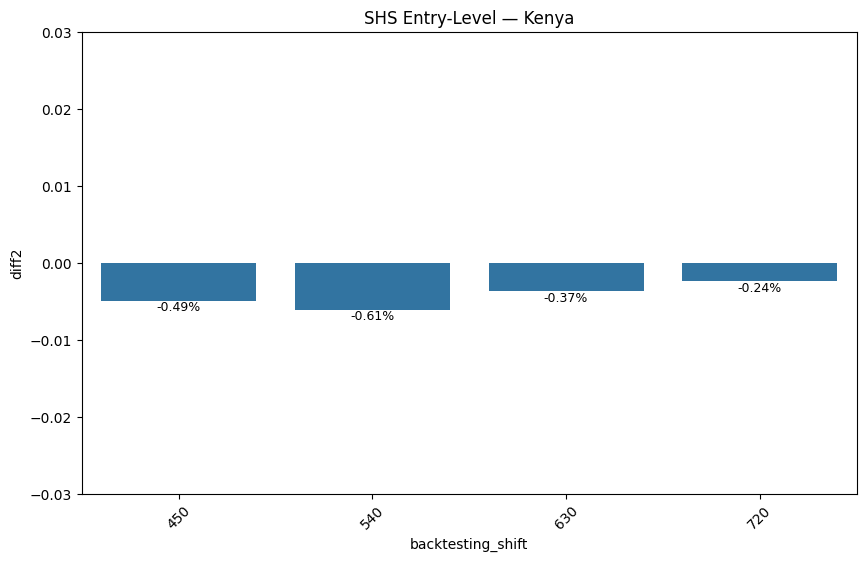

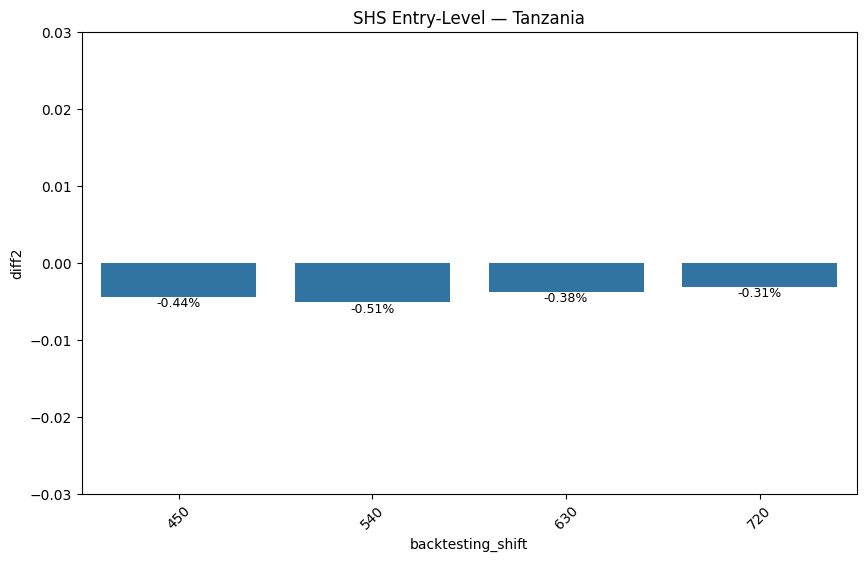

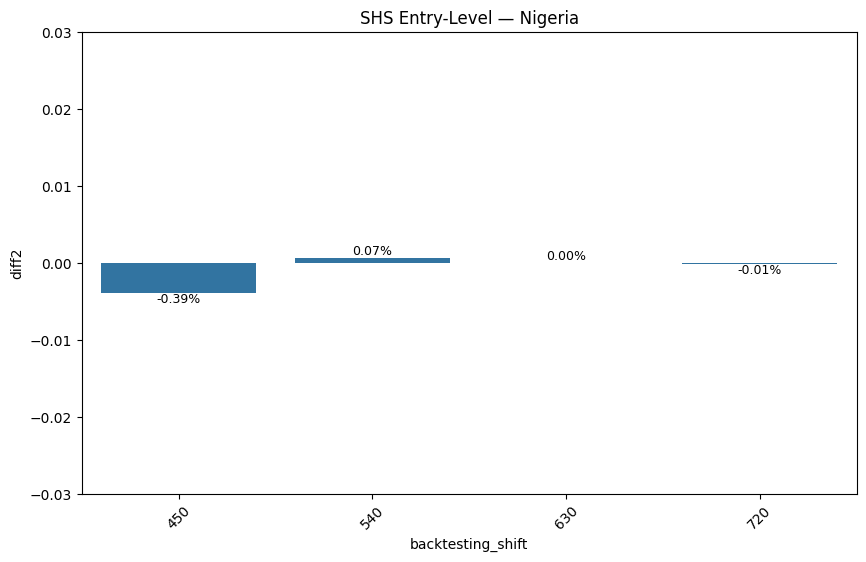

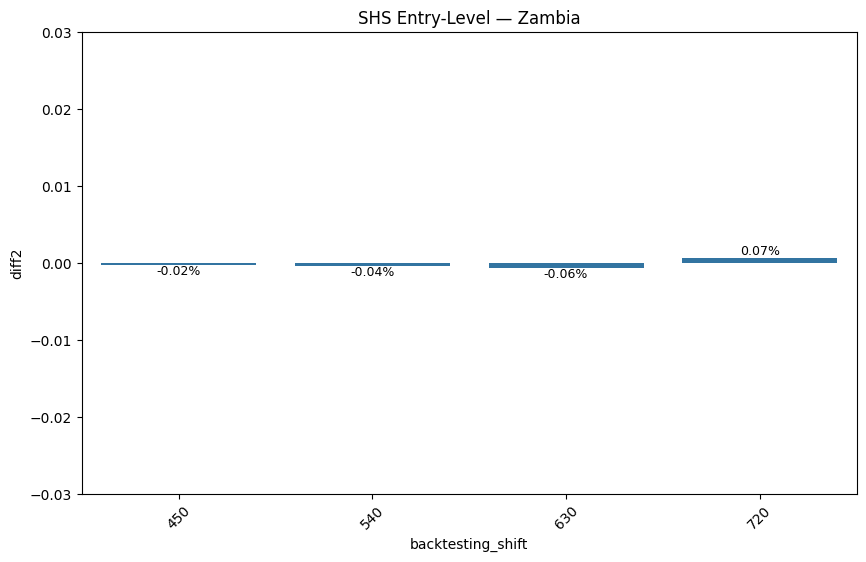

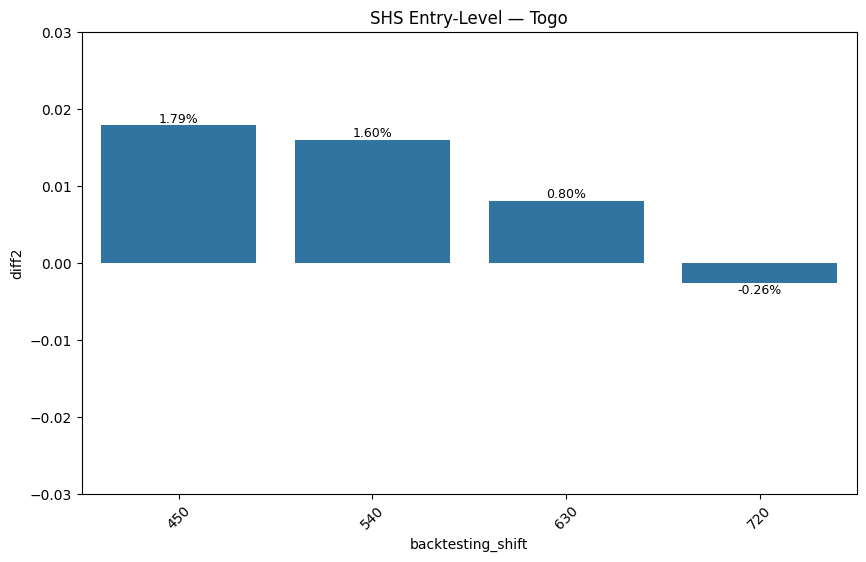

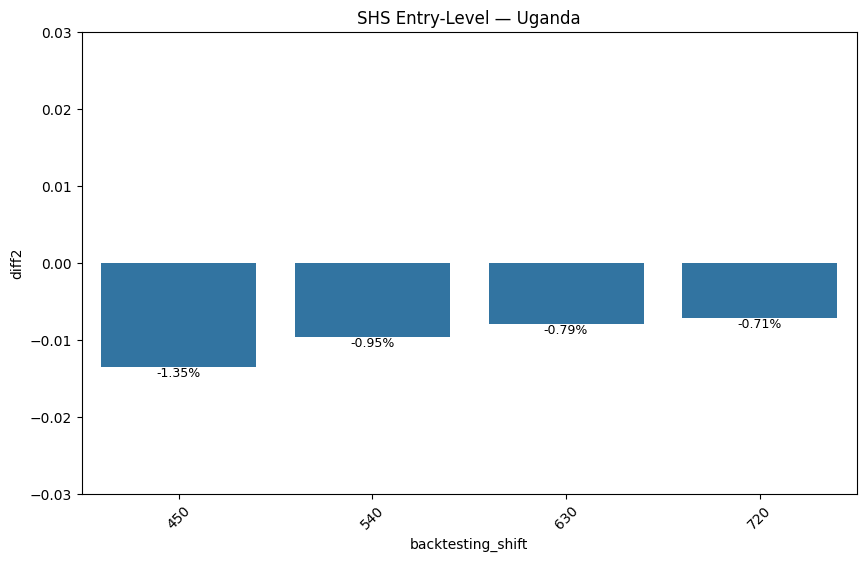

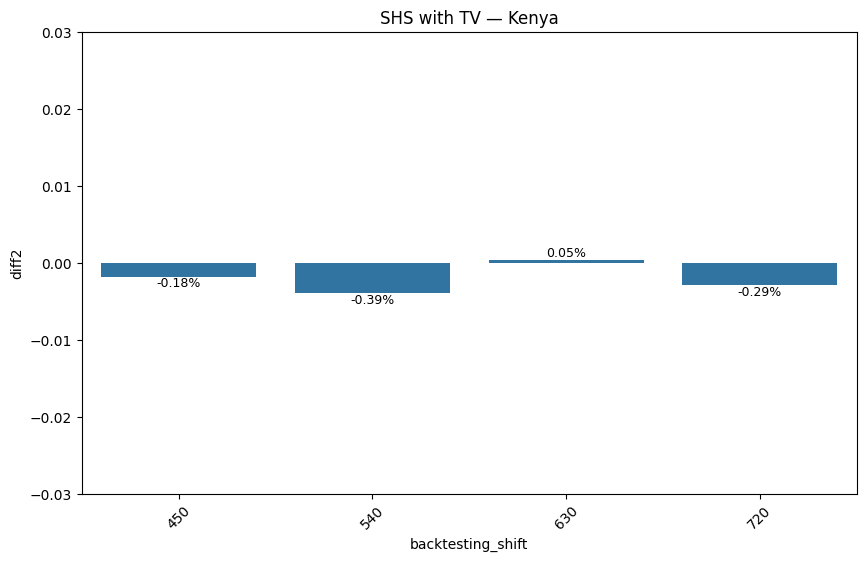

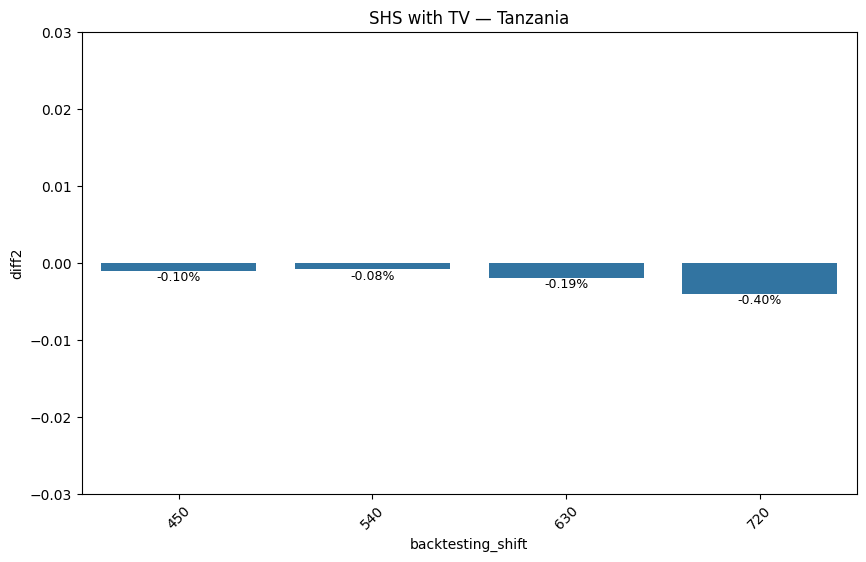

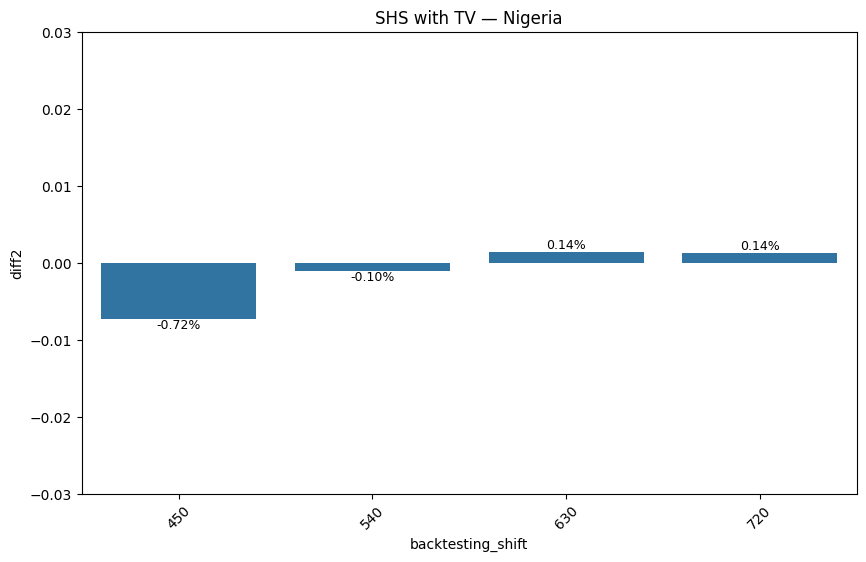

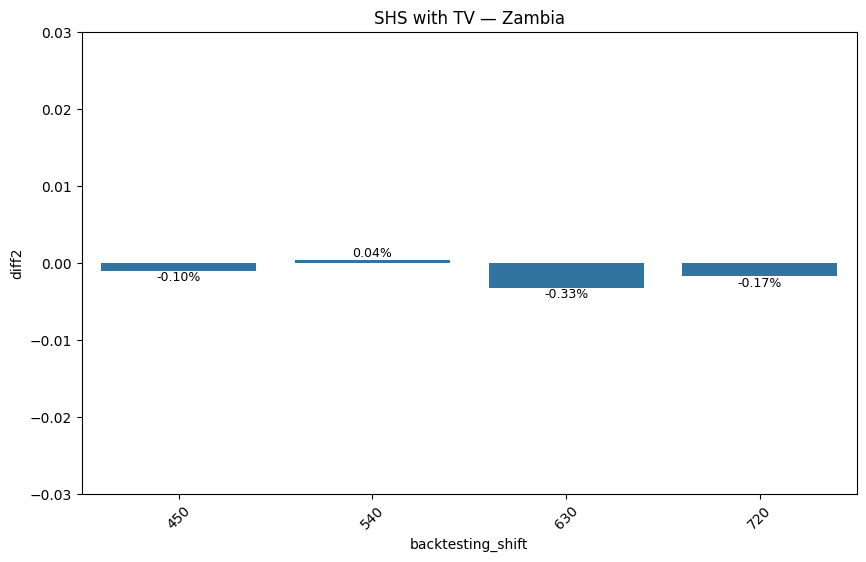

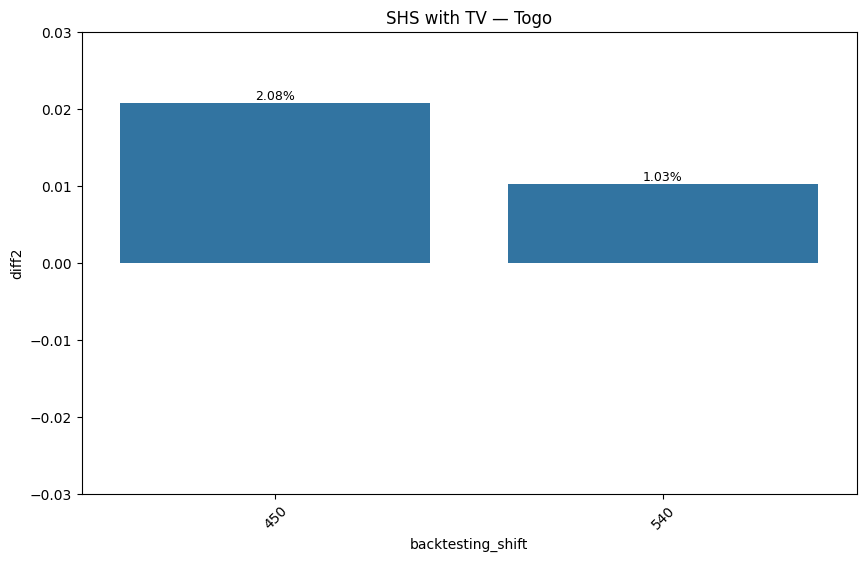

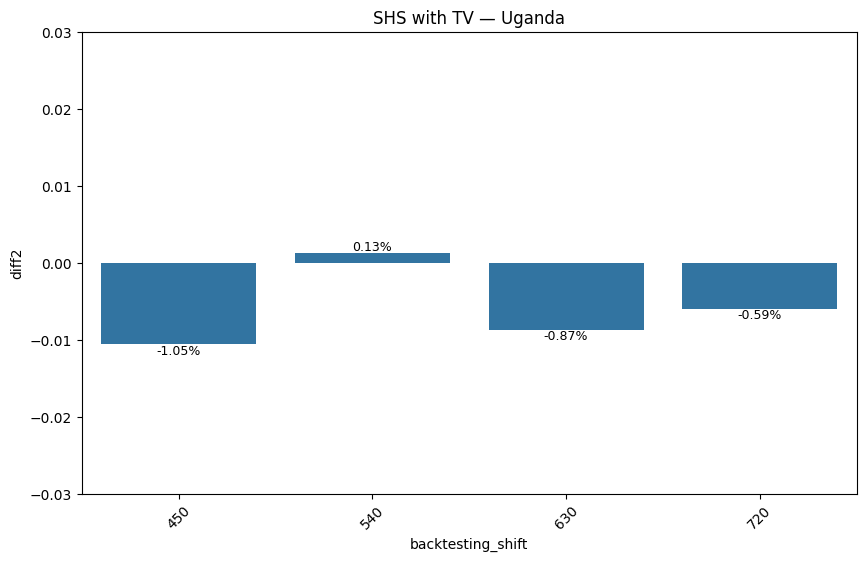

In [22]:
for product_group in ["Lanterns", "SHS Entry-Level", "SHS with TV"]:
    for country in ["Kenya", "Tanzania", "Nigeria", "Zambia", "Togo", "Uganda"]:
        plt.figure(figsize=(10, 6))
        plt.ylim((-0.03, 0.03))

        subset = discrepancies_country[
            (discrepancies_country.country == country) &
            (discrepancies_country.product_group == product_group)
        ]

        ax = sns.barplot(
            data=subset,
            x="backtesting_shift",
            y="diff2"
        )

        # add labels in percent (2 dp)
        for container in ax.containers:
            ax.bar_label(container, labels=[f"{v*100:.2f}%" for v in container.datavalues], fontsize=9)

        plt.xticks(rotation=45)
        plt.title(f"{product_group} — {country}")
        plt.show()

In [23]:
products = ["Lanterns", "Phones", "SHS Entry-Level", "SHS with TV", "SHS without TV", "SHS Entry-Level Upgrade", "SHS with TV Upgrade"]
discrepancies_country[discrepancies_country.product_group.isin(products)].groupby("country").agg(
    mean_diff = ("diff2", "mean"),
    min_diff = ("diff2", "min"),
    max_diff = ("diff2", "max")
).reset_index()

,country,mean_diff,min_diff,max_diff
0,Cameroon,-0.004766,-0.021804,0.002714
1,India,-0.005654,-0.013943,-0.001159
2,Kenya,-0.003023,-0.011879,0.001835
3,Malawi,-0.001107,-0.005361,0.001047
4,Mozambique,-0.005499,-0.013899,0.002373
5,Myanmar (Burma),0.000719,-0.000772,0.004840
6,Nigeria,-0.000401,-0.007244,0.003282
7,South Africa,-0.000018,-0.000147,0.000112
8,Tanzania,-0.003560,-0.012587,0.000711
9,Togo,0.011712,-0.002639,0.020762
